In [1]:
"""
Dataset:

Subreddit content and binary stress indicator dataset:
https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction/data

Research Questions:

- How feasible is it to build an NLP model which successfully predicts stress
  based on subreddit content?
- Does the accuracy of the model predictions vary by subreddit topic/theme?
- Does the likelihood of poster exhibiting stress vary by time of day?

What we are going to do:

1) Data exploration, word cloud (together so we all understand the dataset) x
2) Preprocessing: x
    - feature engineering x
    - tokenisation, vectorisation etc
    - dealing with the timestamp variable x
    - simplifying the subreddit topics x?
3) Model building – sentiment analysis neural network predicting
    - 1 = stress, 0 = no stress
4) Model testing – train, test, split
5) Assess performance – accuracy
6) Stratification:
    - By theme
    - By time of day
7) Visualisation
8) Discuss and describe outputs and potential uses
    (ideally with reference to existing literature on stress and social media)

Outputs:

- Stress prediction model
- Recommendations for potential uses e.g. healthcare
- Visualisation of analysis of the relationship between 'stress-posting' and
  time of day or subreddit theme

Work on the projects:

Approach/Method:

"""
### environment required

"\nDataset:\n\nSubreddit content and binary stress indicator dataset:\nhttps://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction/data\n\nResearch Questions:\n\n- How feasible is it to build an NLP model which successfully predicts stress \n  based on subreddit content?\n- Does the accuracy of the model predictions vary by subreddit topic/theme?\n- Does the likelihood of poster exhibiting stress vary by time of day?\n\nWhat we are going to do:\n\n1) Data exploration, word cloud (together so we all understand the dataset) x\n2) Preprocessing: x\n    - feature engineering x\n    - tokenisation, vectorisation etc\n    - dealing with the timestamp variable x\n    - simplifying the subreddit topics x?\n3) Model building – sentiment analysis neural network predicting\n    - 1 = stress, 0 = no stress\n4) Model testing – train, test, split\n5) Assess performance – accuracy\n6) Stratification:\n    - By theme\n    - By time of day\n7) Visualisation\n8) Discuss and describe outputs and

In [6]:
### Import Libararies
import numpy as np
import pandas as pd
import time ##for processing epoch times
from wordcloud import WordCloud, STOPWORDS
import string
import matplotlib.pyplot as plt

from PIL import Image
import urllib.request

import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import TextVectorization

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import TextVectorization

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split


In [7]:
### Read in data
data = pd.read_csv("Stress.csv")

In [8]:
### Data Exploration
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


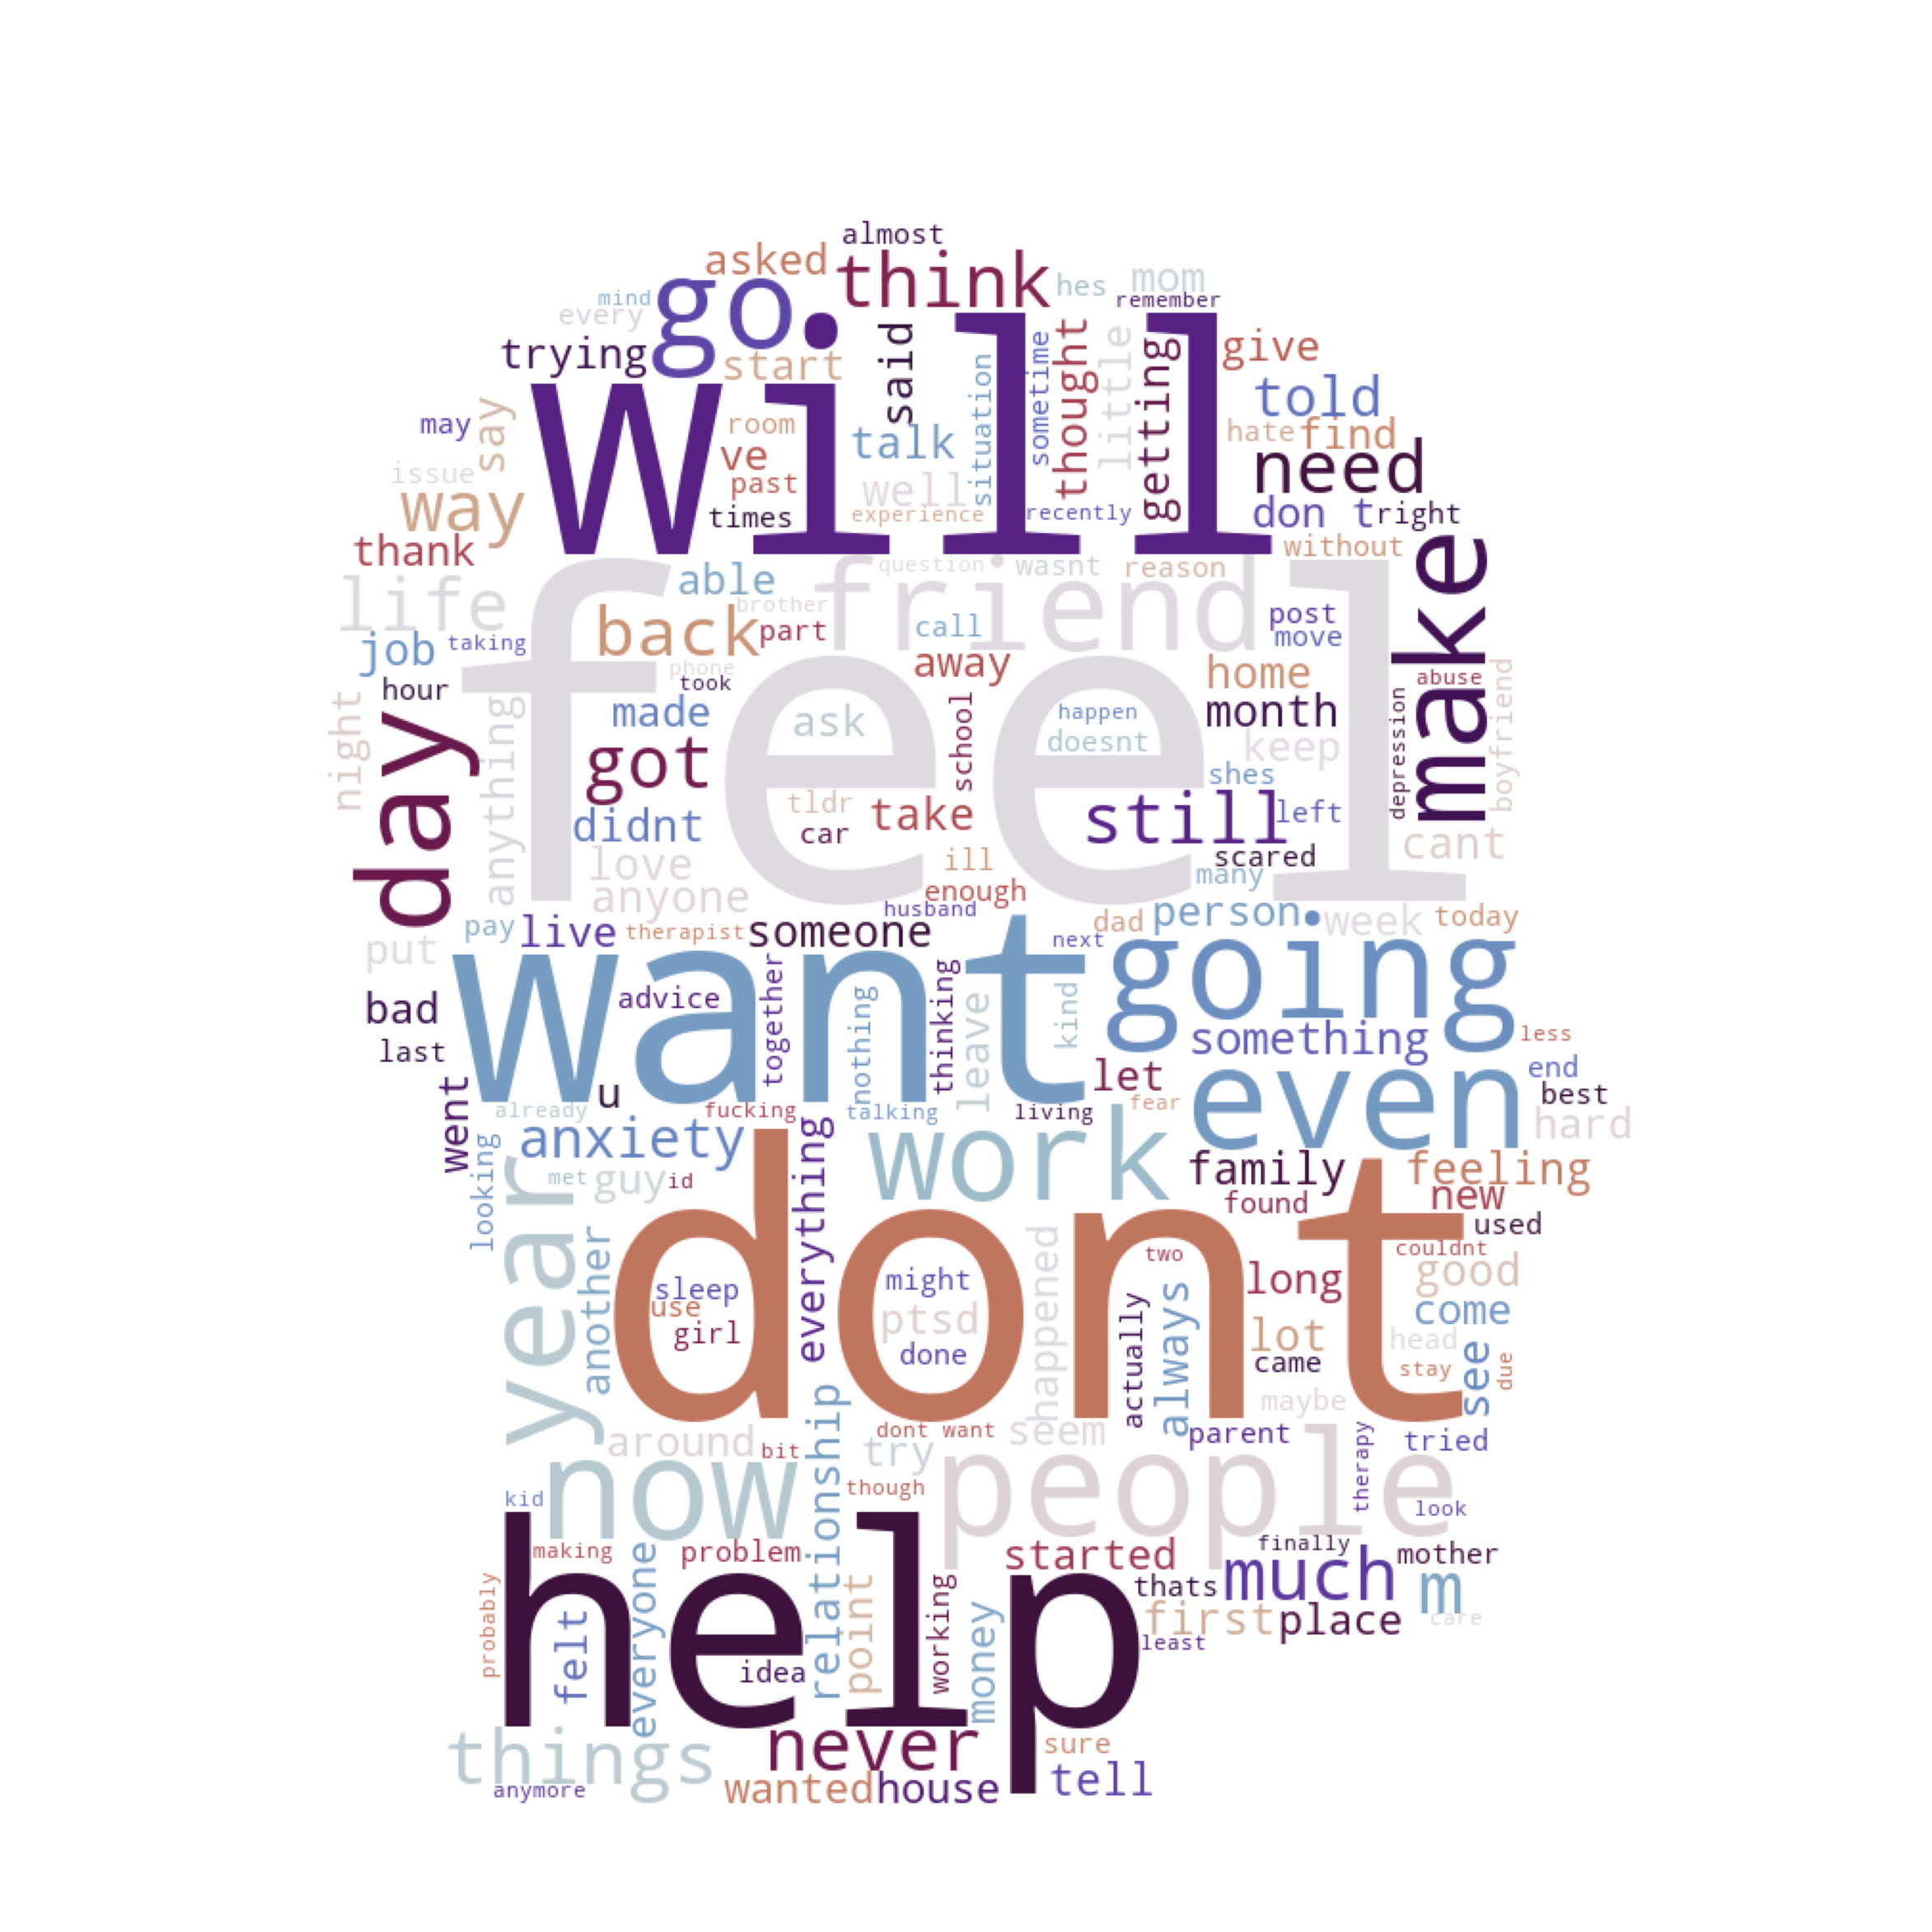

In [9]:
### Wordcloud

# Convert rows into one big piece of text
full_text = ''.join(data['text'].tolist())

# Stopwords list
stopwords = set(STOPWORDS)
custom_stopwords = ["really","im","ive","thing","time","know","one","s"]
stopwords.update(custom_stopwords)

# Tokenize the text
tokens = full_text.split()
# Map punctuation
punctuation_mapping_table = str.maketrans('', '', string.punctuation)
# Strip tokens of punctuation
tokens_stripped_of_punctuation = [token.translate(punctuation_mapping_table)
                                  for token in tokens]
# Convert to lower case
lower_tokens = [token.lower() for token in tokens_stripped_of_punctuation]
# Revert to one single string
joined_string = (" ").join(lower_tokens)

urllib.request.urlretrieve(
  'https://as2.ftcdn.net/v2/jpg/03/07/84/35/1000_F_307843531_nTtONdS84agH7bSt02Sv7JLE7a1noLPS.jpg',
   "brain.jpg")

brain_mask = np.array(Image.open('brain.jpg'))

# Make the wordcloud
wordcloud = WordCloud(background_color = 'white',
                      mask = brain_mask,
                      colormap = 'twilight',
                      stopwords = stopwords).generate(joined_string)

# We set the size of the figure
plt.figure(figsize=(30,40))

# Turn off axes
plt.axis("off")

# Then use imshow to plot an image (here, our wordcloud)
plt.imshow(wordcloud)


From the wordcloud, it does not seem that subreddits explicitly contain the word 'stress'.

Words seen that could be relevant include feel, hard, work, relationship, anxiety.

In [ ]:
### Data preparation
data.dtypes

In [10]:
### Feature Engineering (epoch time)
# convert the time in seconds since the epoch to a readable format
data['time'] = pd.to_datetime(
    data['social_timestamp'], unit='s', utc=True
).dt.tz_convert(tz="US/Eastern")

data['hour'] = pd.to_datetime(data['time']).dt.hour


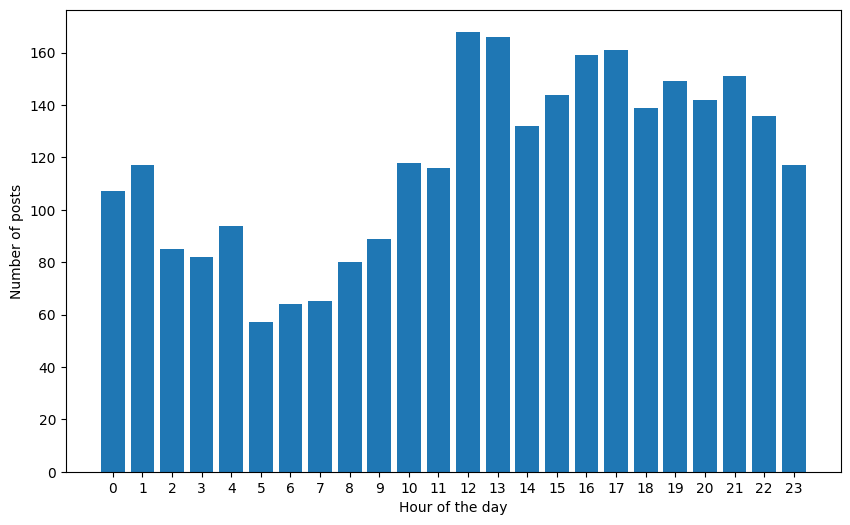

In [12]:
### Plotting posts by time of day and stress indicator
hour_counts = data['hour'].value_counts().sort_index()

plt.figure(figsize = (10,6))
plt.bar(hour_counts.index, hour_counts.values)
plt.xlabel('Hour of the day')
plt.ylabel('Number of posts')
plt.xticks(hour_counts.index)
plt.show()
# ticks
plt.show()

In [16]:
### Feature Engineering (subreddit themes)
data['Subreddit (grouped)'] = np.where(
    data['subreddit'].str.contains(r"homeless|almosthomeless"), "homeless",
    np.where(data['subreddit'].str.contains(r"survivorsofabuse|domesticviolence"), "abuse",
np.where(data['subreddit'].str.contains(r"ptsd|anxiety"), "mental health",
    data['subreddit'])))

hour_counts = data['hour'].value_counts().sort_index()


data['Subreddit (grouped)'].value_counts()

Subreddit (grouped)
mental health    1087
abuse             561
relationships     552
assistance        289
homeless          248
stress             64
food_pantry        37
Name: count, dtype: int64

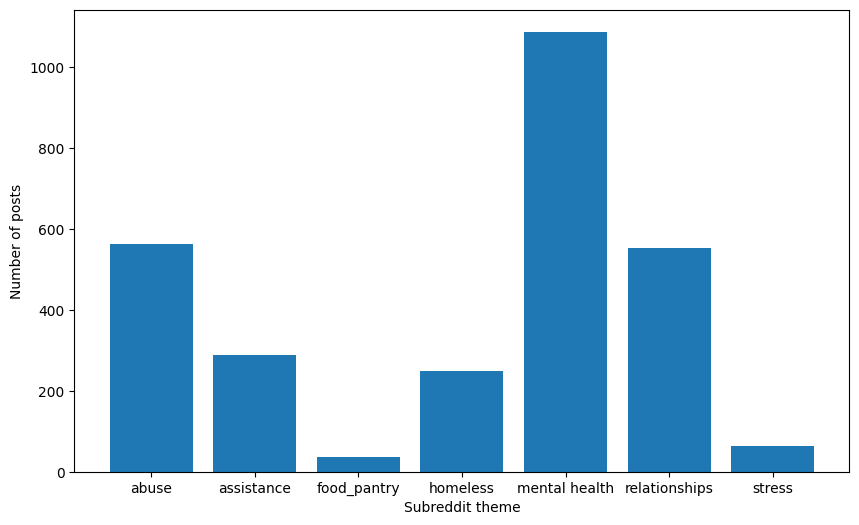

In [17]:
### Plotting posts by subreddit theme
theme_counts = data['Subreddit (grouped)'].value_counts().sort_index()

plt.figure(figsize = (10,6))
plt.bar(theme_counts.index, theme_counts.values)
plt.xlabel('Subreddit theme')
plt.ylabel('Number of posts')
plt.xticks(theme_counts.index)
plt.show()

In [18]:
### Feature Engineering (time of day categories)
data['time_of_day'] = np.where(
    (data['hour'] > 4) & (data['hour'] < 12), 'morning',
    np.where((data['hour'] >= 12) & (data['hour'] < 18), 'afternoon',
    np.where((data['hour'] >= 18) & (data['hour'] < 23), 'evening',
    np.where((data['hour'] >= 23) | (data['hour'] < 5), 'night', 'check'
            )
        )
    )
)

data['time_of_day'].value_counts()

time_of_day
afternoon    930
evening      717
night        602
morning      589
Name: count, dtype: int64

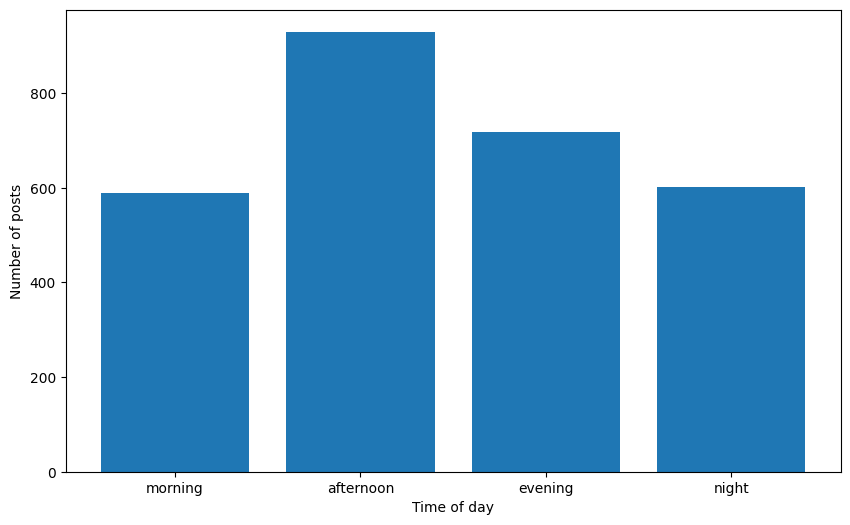

In [19]:
### Plotting posts by time of day
time_of_day_counts = data['time_of_day'].value_counts().sort_index()
order = ['morning', 'afternoon', 'evening', 'night']
time_of_day_counts = time_of_day_counts.reindex(order)

plt.figure(figsize = (10,6))
plt.bar(time_of_day_counts.index, time_of_day_counts.values)
plt.xlabel('Time of day')
plt.ylabel('Number of posts')
plt.xticks(time_of_day_counts.index)
plt.show()

In [21]:
### Data split into train, test, valid
#data_no_stress = data[data['label']==0]
#data_stress = data[data['label']==1]

X = data.copy()
y = X.pop('label')
###split into stress and no stress, 0 and 1s
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#X_train = tf.convert_to_tensor(X_train)
#X_test = tf.convert_to_tensor(X_test)
#X_valid = tf.convert_to_tensor(X_valid)
#y_train = tf.convert_to_tensor(y_train)
#y_test = tf.convert_to_tensor(y_test)
#y_valid = tf.convert_to_tensor(y_valid)

#data_feature = data.columns.to_list()

#data_features = data.copy()
#data_labels = data_features.pop('label')
#normalize = layers.Normalization()
#normalize.adapt(data_features)





raw_train_ds = data.sample(frac = 0.2, random_state = 1)

raw_val_ds = raw_train_ds.sample(frac = 0.2, random_state = 1)

raw_train_ds = raw_train_ds[~ raw_train_ds.index.isin(raw_val_ds.index)]

raw_test_ds = data[~ data.index.isin(raw_train_ds.index)]

# raw_train_ds = tf.convert_to_tensor(raw_train_ds)
# raw_val_ds = tf.convert_to_tensor(raw_val_ds)
# raw_test_ds = tf.convert_to_tensor(raw_test_ds)

In [22]:
raw_train_ds

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,time,hour,Subreddit (grouped),time_of_day
1287,relationships,7u2d6k,"(7, 12)","Plus, we’re using his car, which will eventual...",0,0.571429,1517331075,2018-01-30 11:51:15-05:00,11,relationships,morning
2532,anxiety,5y4goa,"(5, 10)","It helps with the physical symptoms, such as p...",1,0.800000,1488931033,2017-03-07 18:57:13-05:00,18,mental health,evening
1146,stress,9wsqkh,"[3, 8]",He has done it to lots of people and says ever...,1,1.000000,1542140663,2018-11-13 15:24:23-05:00,15,stress,afternoon
2138,ptsd,8nn63n,"[5, 10]",Here's a homebaked metaphor. This is only a re...,0,1.000000,1527809615,2018-05-31 19:33:35-04:00,19,mental health,evening
1087,assistance,8ujbq0,"(3, 8)",The survey will only take about 5 to 10 minute...,0,1.000000,1530191897,2018-06-28 09:18:17-04:00,9,assistance,morning
...,...,...,...,...,...,...,...,...,...,...,...
1044,ptsd,7t81kz,"(5, 10)",I've moved to a safe and accepting space and h...,0,1.000000,1517003954,2018-01-26 16:59:14-05:00,16,mental health,afternoon
56,ptsd,7hzoqz,"[5, 10]",During the pregnancy and after the (traumatic)...,0,0.800000,1512582269,2017-12-06 12:44:29-05:00,12,mental health,afternoon
208,anxiety,7seukl,"[0, 5]",My problems started after my first panic attac...,1,0.666667,1516718815,2018-01-23 09:46:55-05:00,9,mental health,morning
2602,homeless,8vpo2r,"[0, 5]","Not actually losing my home at the moment, so ...",1,1.000000,1530595671,2018-07-03 01:27:51-04:00,1,homeless,night


In [ ]:
### Data Normalisation process

In [63]:
### Stress Level Model set up/parameters

# Specify batch size to pass through the model
batch_size = 32
# Set a random number seed so that we get the same results with each test
seed = 42
# Specify the maximum number of tokens to include
max_features = 10000
# Specify the maximum length of subreddit post to include
sequence_length = 250

# Vectorization
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Get just the reddit post text in train_text
train_text = raw_train_ds['text'].map(lambda x, y:x)
vectorize_layer.adapt(train_text)

# Create a function to apply the vectorize_layer
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Apply this to all three datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Specify an embedding dimension - this is how many nodes each layer will have
embedding_dim = 16

# Set the dropout rate
dropout = 0.2

# Specify min_delta as min_improvement, for early stopping
# This is the minimum amount of improvement required to keep going
min_improvement = 0.001

# Specify epochs
# One epoch = one run of all batches of training data going through the network
epochs = 20

TypeError: <lambda>() missing 1 required positional argument: 'y'

In [ ]:
### Build the Stress Level Model

model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim),
    layers.Dropout(dropout),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(dropout),
    layers.Dense(1)])

# Compile the model and specify accuracy as a performance metric
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Set up early stopping - this will monitor the accuracy
# min_delta represents the minimum amount of improvement required to keep going
earlystop_callback = EarlyStopping(
    monitor='val_accuracy',
    min_delta=min_improvement,
    patience=1)


In [ ]:
### Train the Stress Level Model

history = model.fit(
    train_ds,
    validation = val_ds,
    epochs = epochs,
    # callbacks=earlystop_callback, # KEEP COMMENTED OUT TO FIRST CHECK FOR OVERFITTING
        verbose = 1
)

In [ ]:
### Evaluate the Stress Level Model on the test dataset

loss, accuracy = model.evaluate(test_ds)
print("Evaluation of Stress Level Model on test dataset")
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2f}")


In [ ]:
### Model Validation Process with Metrics

In [ ]:
### Model stratified by subreddit category

In [ ]:
### Model stratified by time of day
# Morning/Afternoon/Evening/Night?